In [2]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil, floor

In [3]:
# Leer train y test
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [4]:
train['idSecuencia'] = pd.to_datetime(train['idSecuencia'])
test['idSecuencia'] = pd.to_datetime(test['idSecuencia'])

In [5]:
# create a dataframe with the mean of udsVenta for each idSku where bolHoliday = 1 in one column and bolHoliday = 0 in another column
train_mean = train.groupby(['idSku', 'bolHoliday'])['udsVenta'].mean().reset_index()
train_mean = train_mean.pivot(index='idSku', columns='bolHoliday', values='udsVenta').reset_index()
train_mean.columns = ['idSku', 'mean_no_holiday', 'mean_holiday']
train_mean.fillna(0, inplace=True)

train_mean['mean_holiday'] = train_mean['mean_holiday'].apply(lambda x: round(x))
train_mean['mean_no_holiday'] = train_mean['mean_no_holiday'].apply(lambda x: floor(x))

train_mean

,idSku,mean_no_holiday,mean_holiday
0,1,16,0
1,2,20,1
2,3,11,1
3,4,10,1
4,5,13,0
5,6,12,0
6,7,11,0
7,8,6,0
8,9,7,0
9,10,7,1


In [6]:
test = test[['idSku', 'idSecuencia', 'bolHoliday', 'udsVenta']]
test = pd.merge(test, train_mean, on='idSku', how='left')
test['udsVenta_pred'] = np.where(test['bolHoliday'] == 1, test['mean_holiday'], test['mean_no_holiday'])
test.drop(['mean_holiday', 'mean_no_holiday'], axis=1, inplace=True)
test.head()

,idSku,idSecuencia,bolHoliday,udsVenta,udsVenta_pred
0,1,2021-11-07,1,0,0
1,1,2021-11-08,0,27,16
2,1,2021-11-09,0,9,16
3,1,2021-11-10,0,0,16
4,1,2021-11-11,0,9,16


In [7]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime
0,1,18,2
1,2,28,4
2,3,28,2
3,4,14,2
4,5,14,4


In [8]:
# create a column named ciclo_aprovisionamiento with sum of diasEntrePedidos and diasLeadtime
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento
0,1,18,2,20
1,2,28,4,32
2,3,28,2,30
3,4,14,2,16
4,5,14,4,18


In [9]:
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])
# iterate over each sku of df_ciclo
for i in range(len(df_ciclo)):

    # get the sku
    sku = df_ciclo.loc[i, 'idSku']

    # get the ciclo_aprovisionamiento
    ciclo_aprovisionamiento = df_ciclo.loc[i, 'ciclo_aprovisionamiento']

    # create a dataframe with the idSku = sku
    df_sku = test[test['idSku'] == sku]
    # create a column with the sum of udsVenta_pred for de last ciclo_aprovisionamiento days
    df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
    df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
    df_sku.dropna(inplace=True)
    prediction = df_sku['udsVenta_pred_sum']
    target= df_sku['udsVenta_sum']
    results = results.append({'idSku': i+1, 'target': target, 'prediction': prediction}, ignore_index=True)

C:\Users\96gar\AppData\Local\Temp\ipykernel_9820\1175757489.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_9820\1175757489.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_9820\1175757489.py:16: SettingWithCopyWarning: 
A value is trying 

In [9]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = results['target'][i]
    p = results['prediction'][i]
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)
results

C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_11900\3209599410.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['RMSE'][i] = rmse(t, p)
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_11900\3209599410.py:25: SettingWithCopy

,idSku,target,prediction,RMSE,MAPE,MASE,SMAPE,RMSSE
0,1,19 264.0 20 276.0 21 249.0 22 ...,19 272.0 20 288.0 21 272.0 22 ...,51.031111,1.459805e-01,4.009136,0.159724,3.532625
1,2,159 486.0 160 495.0 161 486.0 162 ...,159 507.0 160 526.0 161 526.0 162 ...,63.169629,1.105280e-01,3.559300,0.100153,3.662586
2,3,285 246.0 286 264.0 287 255.0 288 ...,285 270.0 286 280.0 287 270.0 288 ...,25.151059,7.440853e-02,2.013829,0.068845,2.199608
3,4,399 105.0 400 114.0 401 123.0 402 ...,399 133.0 400 142.0 401 142.0 402 ...,24.294651,1.963733e-01,2.578052,0.173096,2.347099
4,5,529 33.0 530 42.0 531 42.0 532 ...,529 195.0 530 208.0 531 208.0 532 ...,49.658927,3.288590e-01,3.698118,0.205600,3.926197
5,6,652 69.0 653 84.0 654 75.0 655 ...,652 132.0 653 144.0 654 132.0 655 ...,39.972620,3.433375e-01,3.837798,0.300039,3.241851
6,7,797 183.0 798 195.0 799 189.0 800 ...,797 264.0 798 275.0 799 264.0 800 ...,57.081459,2.567887e-01,7.272538,0.221375,6.257421
7,8,907 62.0 908 77.0 909 79.0 910 ...,907 60.0 908 66.0 909 66.0 910 ...,32.521788,3.308463e-01,4.384362,0.362597,4.277003
8,9,1032 96.0 1033 108.0 1034 114.0 1035...,1032 42.0 1033 49.0 1034 49.0 1035 ...,60.754012,5.220378e-01,10.107426,0.714594,7.783402
9,10,1162 82.0 1163 91.0 1164 90.0 1165 ...,1162 65.0 1163 71.0 1164 71.0 1165 ...,21.532199,4.445145e-01,3.343247,0.341446,2.995519


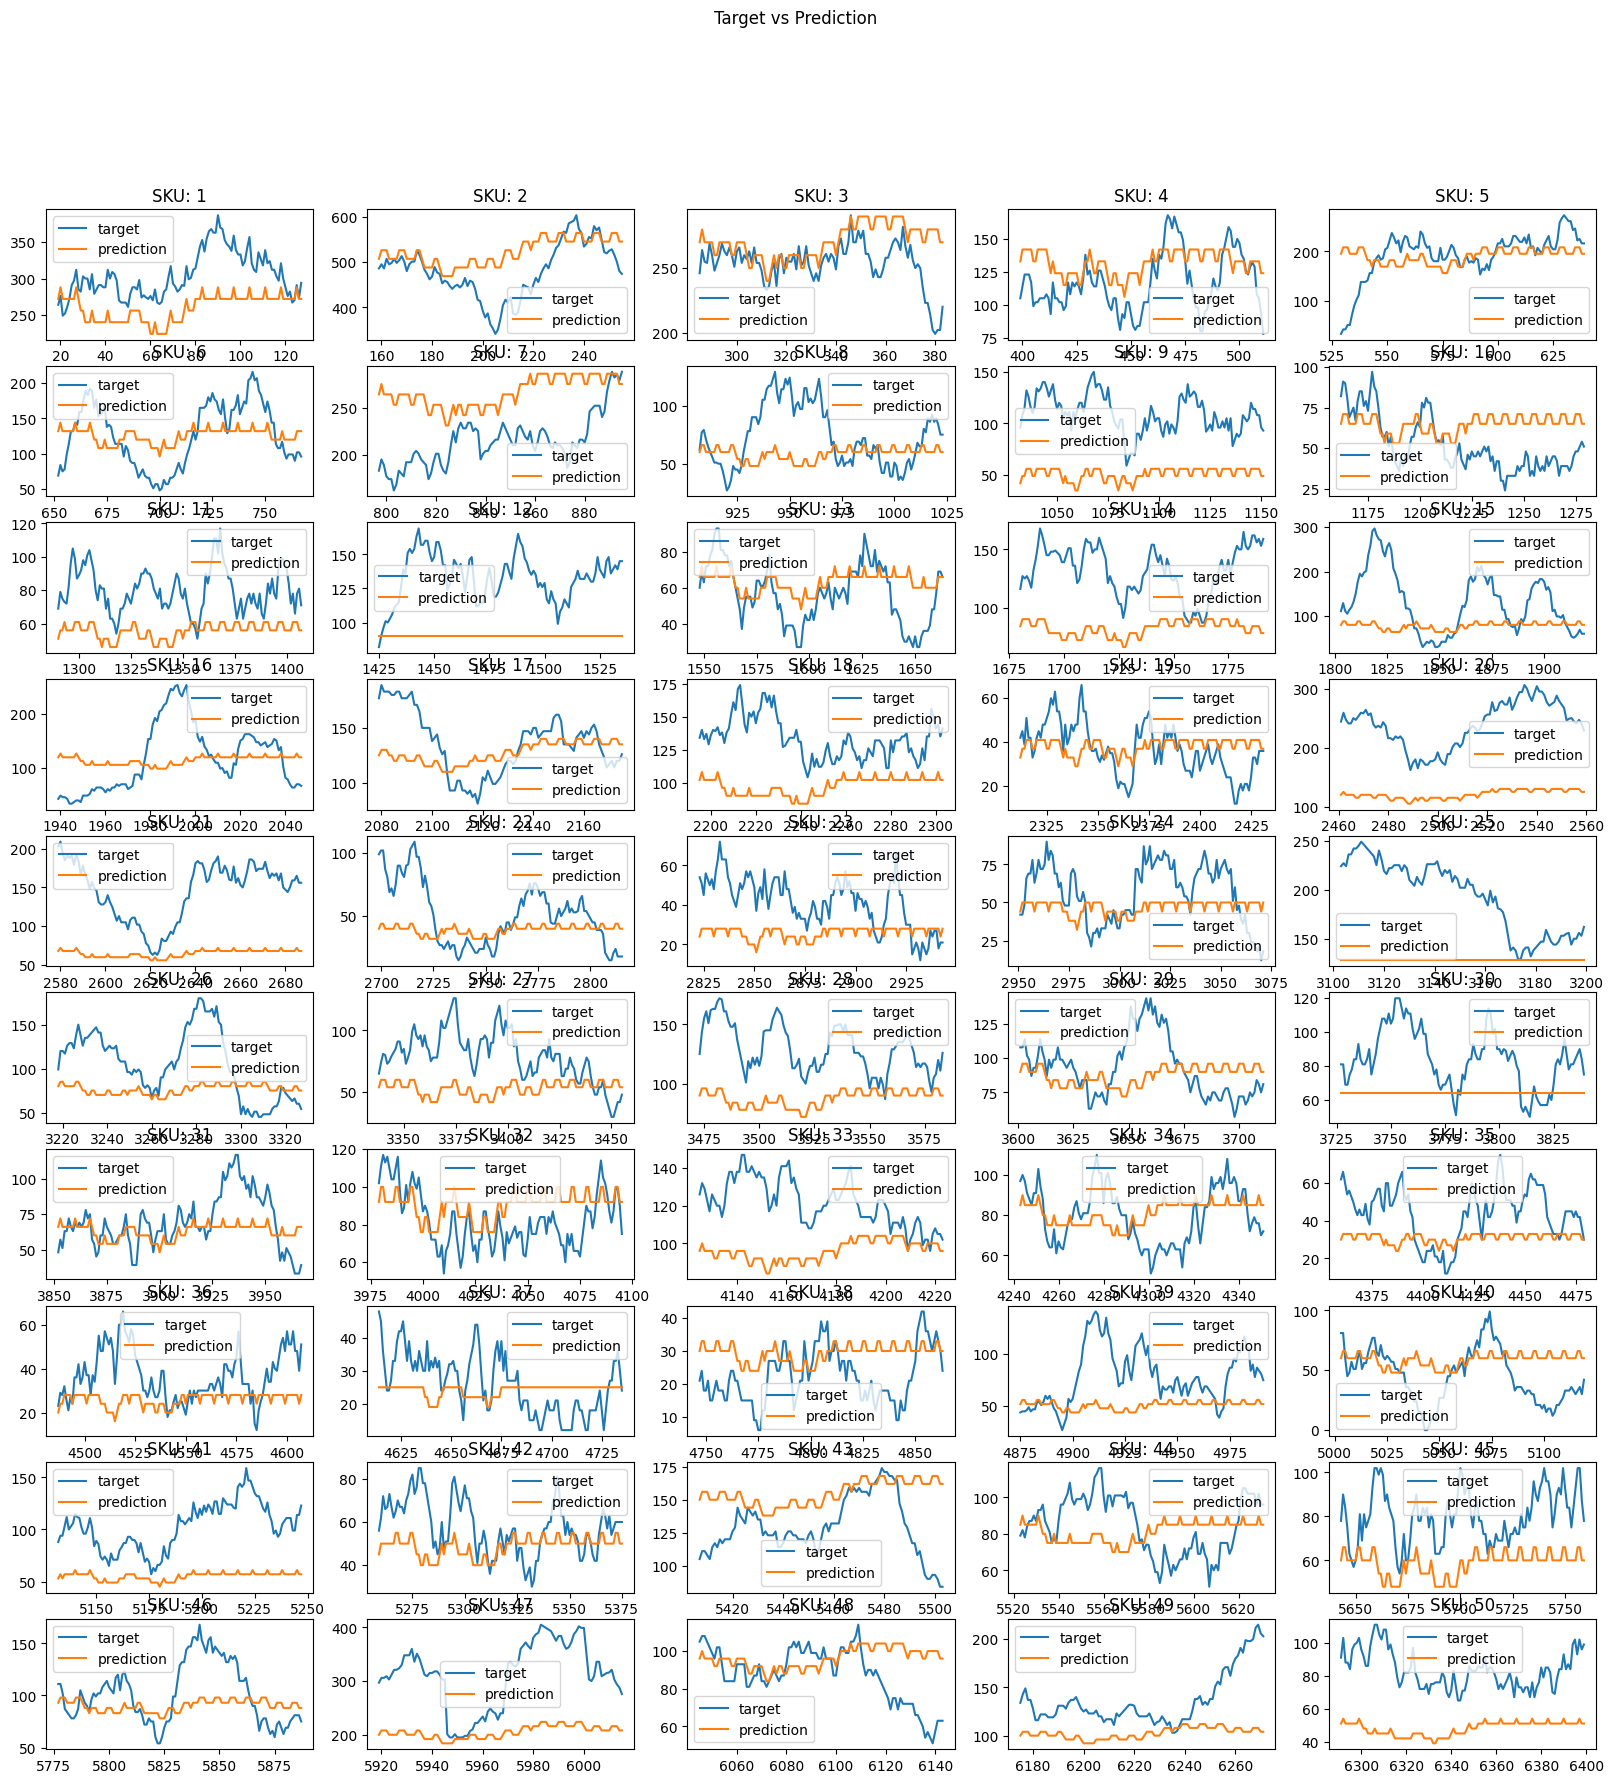

In [10]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()

In [11]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     3.831977e+01
MAPE     8.314338e+13
MASE     5.909763e+00
SMAPE    3.351374e-01
RMSSE    5.150084e+00
dtype: float64

In [12]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

,idSku,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [13]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE
0,1,18,2,20,1.370002,51.031111
1,2,28,4,32,1.370002,63.169629
2,3,28,2,30,1.370002,25.151059
3,4,14,2,16,1.370002,24.294651
4,5,14,4,18,1.370002,49.658927


Stock de seguridad = Factor servicio *RMSE * raíz del ciclo de aprovisionamiento

In [14]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['ciclo_aprovisionamiento'])), axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad
0,1,18,2,20,1.370002,51.031111,375
1,2,28,4,32,1.370002,63.169629,587
2,3,28,2,30,1.370002,25.151059,226
3,4,14,2,16,1.370002,24.294651,160
4,5,14,4,18,1.370002,49.658927,346


In [15]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad,coste_stock_diario
0,1,18,2,20,1.370002,51.031111,375,25.687529
1,2,28,4,32,1.370002,63.169629,587,40.209546
2,3,28,2,30,1.370002,25.151059,226,15.481018
3,4,14,2,16,1.370002,24.294651,160,10.960013
4,5,14,4,18,1.370002,49.658927,346,23.701027


In [16]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 2169.9€
Coste stock total anual: 792013.5€
